In [34]:
import Constants
import Dynamics
import Bfield

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [264]:
Bstrength = Constants.Gauss2Tesla(.1e-6) # 2423.628e-6

B = np.asarray([0,0,Bstrength])
m_per_AU = Constants.AU2meters(1.) # meters in 1 AU
c = Constants.lightspeed_m_per_s() # speed of light in [meters / second]

ratio = 1./200e18 # 92./2e18

radius = Constants.meters2AU((1./c)*(1./ratio)*(1./Bstrength))

position = np.asarray([0,-radius,0])
beta = np.asarray([-1,0,0])

save = np.array([position])

dist_lim = np.pi * radius * 2. * 1.05 
step = dist_lim / 1e6

dist = 0.
target = .01
target_step = .01
while (dist < dist_lim):
    
    beta = beta / np.sqrt( np.dot(beta, beta) )
    alpha = m_per_AU * ratio * np.cross( beta, c*B )
    
    beta = beta + (alpha * step)
    position = position + (beta * step)
    dist += step
    
    progress = dist / dist_lim
    if (progress < .01 or progress > .94 and progress < .96):
        save = np.concatenate((save, [position]))        
    elif (progress >= target):
        save = np.concatenate((save, [position]))
        print(str(np.round(100*target)), end=' ', flush=True)
        target += target_step 

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 

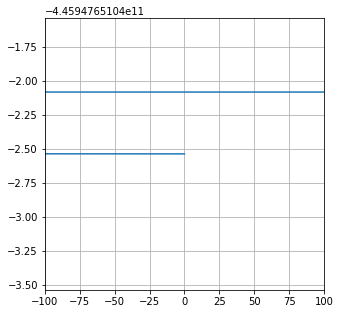

In [267]:
plt.figure(figsize=[5,5])
x = [s[0] for s in save]
y = [s[1] for s in save]
plt.plot(x,y)

#plt.xlim(-1.2*radius,1.2*radius)
#plt.ylim(-1.2*radius,1.2*radius)

e = 1.
plt.xlim(-100*e,100*e)
plt.ylim(-radius - e,-radius + e)

plt.grid()
plt.show()

In [253]:
radius

299195807849755.44

In [242]:
Constants.AU2meters(.5e-8)

747.9893535

In [268]:
Constants.AU2meters(.5 / (np.pi * radius * 2.) * 6.)

0.16017064251106058

In [244]:
Constants.AU2meters(step)

1973897400.6519423

In [269]:
radius

445947651042.53864

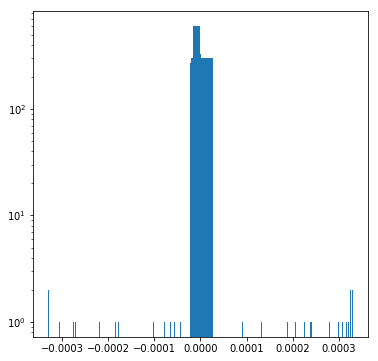

In [290]:
plt.figure(figsize=[6,6])
plt.yscale('log')
plt.hist( 100.*(np.sqrt((save*save).sum(1)) - radius)/radius, bins=1000 )
plt.show()

In [2]:
def GetZenith(l, b):
    """
    l = degrees longitude (0 points in +x direction)
    b = degrees latitude (0 is the x-y plane)
    returns solar system coordinates and zenith unit vector
    """
    Re = Constants.RadiusAU('earth')
    l_rad = l * np.pi / 180.
    b_rad = b * np.pi / 180.
    
    zenith_x = np.cos(b_rad) * np.cos(l_rad)
    zenith_y = np.cos(b_rad) * np.sin(l_rad)
    zenith_z = np.sin(b_rad)
    
    zenith = np.asarray([zenith_x, zenith_y, zenith_z])
    earth  = Re * zenith
    solar  = np.asarray([1,0,0]) + earth
    
    return solar, zenith

In [57]:
def GetStartPoints(l, b, n, radius=20, acceptance=90):
    """
    l = degrees longitude (0 points in the +x direction)
    b = degrees latitude (0 is the x-y plane)
    n = number of points to get
    radius = distance away from sun in AU
    acceptance = degrees off of zenith, should be 90 (earth surface plane) or less
    returns start location and initial heading vectors
    """
    def UnitVectors(n):
        """
        lr = radians
        br = radians
        return unit vector
        """
        lr = 2.*np.pi * np.random.random(size=n)
        br = np.pi * np.random.random(size=n) - np.pi/2.
        x = np.cos(br) * np.cos(lr)
        y = np.cos(br) * np.sin(lr)
        z = np.sin(br)
        return np.column_stack((x,y,z))
    
    earth, zenith = GetZenith(l, b)
    
    points = np.array([]).reshape(0,3)
    trajectory = np.array([]).reshape(0,3)
    
    while (len(points) < n):
        p = radius * UnitVectors(n - len(points))
        t = earth - p
            
        # make unit vector
        t = t / np.sqrt( (t*t).sum(1) ).reshape(1,-1).T
            
        angles = 180. / np.pi * np.arccos( np.dot(t, -zenith) )
    
        # keep only points forward of the earth surface plane
        condition = (angles <= acceptance)
    
        points = np.concatenate((points, p[condition]))
        trajectory = np.concatenate((trajectory, t[condition]))
    
    return points, trajectory

In [4]:
def HaversineNormalized(lat1, lon1, lat2, lon2):
    """ Normalized the earth radius aka 1 = Re
    """
    lat1 *= np.pi / 180.
    lon1 *= np.pi / 180.
    lat2 *= np.pi / 180.
    lon2 *= np.pi / 180.
    
    part1 = np.sin( (lat2 - lat1) / 2. )**2.
    part2 = np.cos(lat1) * np.cos(lat2)
    part3 = np.sin( (lon2 - lon1) / 2. )**2.

    return 2. * np.arcsin( np.sqrt(part1 + part2 * part3) )

In [47]:
def Trajectories(l, b, ratio, n=1):
    
    m_per_AU = Constants.AU2meters(1.) # meters in 1 AU
    c = Constants.lightspeed_m_per_s() # speed of light in [meters / second]
    Re = Constants.RadiusAU('earth')
    E = np.asarray([1,0,0])
    
    #trajectories = []
    #latlons = []
     
    out = []
    
    points, heading = GetStartPoints(l, b, n)
    for point, heading in zip(points, heading):
        
        position = np.asarray(point)
        #save = np.asarray([position])
        beta = np.asarray(heading)
        
        r_earth = position - E
        dist_earth = np.sqrt( np.dot(r_earth, r_earth) )
        limit = dist_earth + 2.*Re
        
        r_hat = r_earth / dist_earth
        cosE = np.dot(beta, -r_hat)
        x = (dist_earth * cosE) - np.sqrt(Re**2 - dist_earth**2 * (1. - cosE*cosE))
        R = r_earth + (x * beta)
        f = np.sqrt(np.dot(R,R)) / Re
        u = R / np.sqrt(np.dot(R,R))
        ll = (180./np.pi) * np.arctan2(u[1], u[0])
        bb = (180./np.pi) * np.arctan2(u[2], np.sqrt(u[0]*u[0] + u[1]*u[1]))
        #if ( (not np.isclose(l, ll, atol=1e-3)) or (not np.isclose(b, bb, atol=1e-3)) ):
        #    print('not close enough, skipping')
        #    print('(l,b) projected = ' + str(ll) + ', ' + str(bb))
        #    continue
        
        step_max = limit / 1e4 #np.log10(limit / 1e4)
        step_mid = 5. * Re #Constants.meters2AU(10e6) #np.log10(Constants.meters2AU(1e3))
        #step_min = Constants.meters2AU(100e3)
        
        near_earth = 5. * Re
        step_slope1 = (step_max - step_mid) / limit
        #step_slope2 = (step_mid - step_min) / near_earth
        
        step = step_slope1 * dist_earth + step_mid #np.power(10., step_slope * dist_earth + step_min)
                
        target = .01
        target_step = .01
        
        dist = 0.
        #save_step = 100
        #save_counter = 0
        while (dist < limit):
    
            beta = beta / np.sqrt( np.dot(beta, beta) )
                        
            B = Bfield.cartesianTesla(position) # [Tesla] 
            alpha = m_per_AU * ratio * np.cross( beta, c*B )
    
            beta = beta + (alpha * step)
            position = position + (beta * step)
            
            r_earth = position - E
            dist_earth = np.sqrt( np.dot(r_earth, r_earth) )
            if (dist_earth > near_earth):
                step = step_slope1 * dist_earth + step_mid
            else:
                r_hat = r_earth / dist_earth
                cosE = np.dot(beta, -r_hat)
                ratical = Re**2 - dist_earth**2 * (1. - cosE*cosE)
                if (ratical < 0.):
                    print('misses the earth, ending this simulation')
                    break
                x = (dist_earth * cosE) - np.sqrt(ratical)
                R = r_earth + (x * beta)
                f = np.sqrt(np.dot(R,R)) / Re
                if (not np.isclose(f, 1.)):
                    print('extrapolation of trajectory failed, skipping')
                    break
                u = R / np.sqrt(np.dot(R,R))
                ll = (180./np.pi) * np.arctan2(u[1], u[0])
                bb = (180./np.pi) * np.arctan2(u[2], np.sqrt(u[0]*u[0] + u[1]*u[1]))
                out.append(HaversineNormalized(b, l, bb, ll) * Constants.RadiusMeters('earth'))
                print(' finished', end='', flush=True)
                break
                #step = step_slope2 * dist_earth + step_min
            
            dist += step
    
            """
            save_counter += 1
            if (save_counter >= save_step):
                save = np.concatenate((save, [position]))

                r_hat = r_earth / dist_earth
                cosE = np.dot(beta, -r_hat)
                x = (dist_earth * cosE) - np.sqrt(Re**2 - dist_earth**2 * (1. - cosE*cosE))
                R = r_earth + (x * beta)
                f = np.sqrt(np.dot(R,R)) / Re
                u = R / np.sqrt(np.dot(R,R))
                ll = (180./np.pi) * np.arctan2(u[1], u[0])
                bb = (180./np.pi) * np.arctan2(u[2], np.sqrt(u[0]*u[0] + u[1]*u[1]))
                savelbf = np.concatenate((savelbf, [np.asarray([ll, bb, f])]))
                
                save_counter = 0
            elif (dist_earth < 1.5 * Constants.RadiusAU('earth')):
                save = np.concatenate((save, [position]))
                
                r_hat = r_earth / dist_earth
                cosE = np.dot(beta, -r_hat)
                x = (dist_earth * cosE) - np.sqrt(Re**2 - dist_earth**2 * (1. - cosE*cosE))
                R = r_earth + (x * beta)
                f = np.sqrt(np.dot(R,R)) / Re
                u = R / np.sqrt(np.dot(R,R))
                ll = (180./np.pi) * np.arctan2(u[1], u[0])
                bb = (180./np.pi) * np.arctan2(u[2], np.sqrt(u[0]*u[0] + u[1]*u[1]))
                savelbf = np.concatenate((savelbf, [np.asarray([ll, bb, f])]))
            """
            progress = dist / limit
            if (progress >= target):
                print(str(np.round(100*target)), end=' ', flush=True)
                target += target_step 
            
            #if (dist_earth <= Constants.RadiusAU('earth')):
            #    print(' finished', end='', flush=True)
            #    break
        print()
        #trajectories.append(save)
        #latlons.append(savelbf)
    
    return out #trajectories, latlons

In [58]:
np.random.seed(0)
start = time.time()
print( Trajectories(-180., 10., 92./20e18) )
end = time.time()
print(end - start)

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0  finished
[1425183.5992938865]
30.71951937675476


In [639]:
np.random.seed(0)

lo = 230.
bo = 60.

t, lbf = Trajectories(lo,bo,92./2e18)

R = t[0][-1]

l = [ x[0] for x in lbf[0] ]
b = [ x[1] for x in lbf[0] ]
f = [ x[2] for x in lbf[0] ]

print(l[-1:])
print(b[-1:])
print(f[-1:])

HaversineNormalized(bo, lo, b[-1], l[-1]) * Constants.RadiusMeters('earth')

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 

C:\Users\EricK\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt


69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 
[nan]
[nan]
[nan]


C:\Users\EricK\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in sqrt


nan

In [53]:
np.random.randint(0, 999999999)

238956051

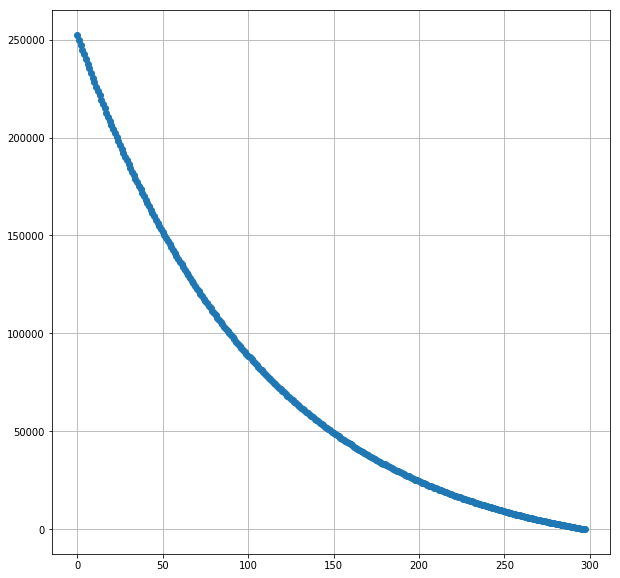

In [660]:
plt.figure(figsize=[10,10])
r = t[0] - np.asarray([1,0,0])
plt.plot(np.sqrt((r*r).sum(1)) / Constants.RadiusAU('earth'), 'o')
#plt.ylim(0,100)
#plt.xlim(250,300)
plt.grid()

In [646]:
l = [ x[0] for x in lbf[0] ]
b = [ x[1] for x in lbf[0] ]
f = [ x[2] for x in lbf[0] ]

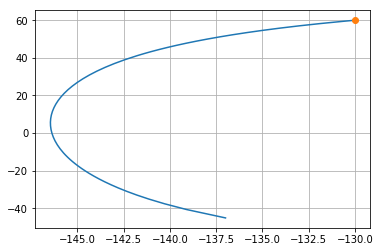

In [648]:
i=0
plt.plot(l[i:],b[i:])
plt.plot(l[i:][0], b[i:][0], 'o')
plt.plot(l[i:][-1], b[i:][-1], 'o')
#plt.ylim(-5e-5,5e-5)
#plt.xlim(-5e-5,5e-5)
plt.grid()

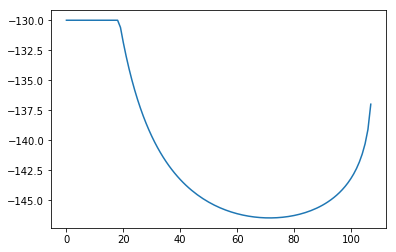

In [649]:
plt.plot(l)

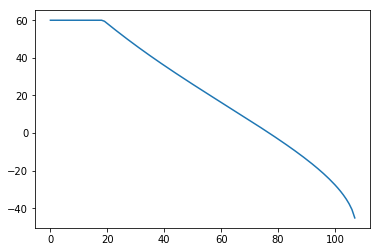

In [650]:
plt.plot( b)

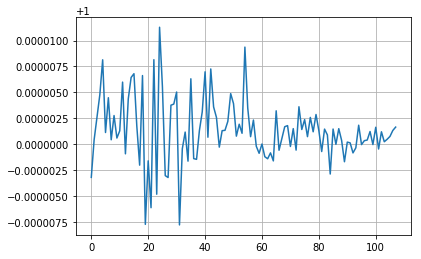

In [651]:
plt.plot(f)
plt.grid()
#plt.ylim(1-1e-10, 1+1e-10)
#plt.xlim(100,120)

In [614]:
f[-5:]

[1.0000000000982705,
 0.9999999999897969,
 1.0000000000098968,
 1.0000000000002944,
 1.0]

In [615]:
def HaversineNormalized(lat1, lon1, lat2, lon2):
    """ Normalized the earth radius aka 1 = Re
    """
    lat1 *= np.pi / 180.
    lon1 *= np.pi / 180.
    lat2 *= np.pi / 180.
    lon2 *= np.pi / 180.
    
    part1 = np.sin( (lat2 - lat1) / 2. )**2.
    part2 = np.cos(lat1) * np.cos(lat2)
    part3 = np.sin( (lon2 - lon1) / 2. )**2.

    return 2. * np.arcsin( np.sqrt(part1 + part2 * part3) )

In [616]:
HaversineNormalized(0., 0., b[-1], l[-1]) * Constants.RadiusMeters('earth')

0.00233003486579294

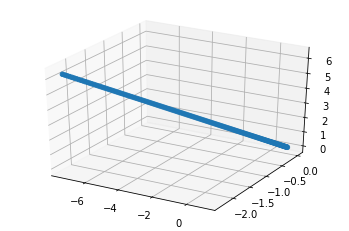

In [658]:
x = [ r[0] for r in t[0] ]
y = [ r[1] for r in t[0] ]
z = [ r[2] for r in t[0] ]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)

In [653]:
from mpl_toolkits.mplot3d import Axes3D

[array([[-7.43655933e+00, -2.35513933e+00,  6.25706833e+00],
        [-7.35258403e+00, -2.33169701e+00,  6.19478738e+00],
        [-7.26939269e+00, -2.30847354e+00,  6.13308786e+00],
        [-7.18697800e+00, -2.28546688e+00,  6.07196434e+00],
        [-7.10533269e+00, -2.26267500e+00,  6.01141145e+00],
        [-7.02444960e+00, -2.24009590e+00,  5.95142386e+00],
        [-6.94432159e+00, -2.21772759e+00,  5.89199629e+00],
        [-6.86494163e+00, -2.19556809e+00,  5.83312350e+00],
        [-6.78630274e+00, -2.17361547e+00,  5.77480034e+00],
        [-6.70839798e+00, -2.15186779e+00,  5.71702165e+00],
        [-6.63122051e+00, -2.13032314e+00,  5.65978236e+00],
        [-6.55476354e+00, -2.10897962e+00,  5.60307744e+00],
        [-6.47902034e+00, -2.08783536e+00,  5.54690189e+00],
        [-6.40398425e+00, -2.06688849e+00,  5.49125078e+00],
        [-6.32964866e+00, -2.04613717e+00,  5.43611920e+00],
        [-6.25600705e+00, -2.02557958e+00,  5.38150231e+00],
        [-6.18305292e+00

In [662]:
np.isclose(1,2)

False